# Mixture Density Networks

A mixture density network is a probabilistic model of the form

$$
    p({\bf t}|{\bf x}) = \sum_{k=1}^K \pi_k({\bf x})\mathcal{N}({\bf t}, {\boldsymbol \mu}_k({\bf x}), {\bf I}\sigma_k^2)
$$

Where the coefficients in the model, namely $\{\pi_k({\bf x})\}_k$, $\{{\boldsymbol \mu}_k({\bf x})\}_k$, and $\{\sigma_k({\bf x})\}_k$ are modelled as the outputs of a feedforward neural nework.

A mixture density network is of use whenever we are presented with multimodal or nongauassian data

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed, normal, uniform, randn
from sklearn.neural_network import MLPRegressor

In [2]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(suppress=True, precision=3)

In [3]:
seed(2718)
nsamples = 100
xn = uniform(low=0, high=1, size=nsamples)
noise = uniform(low=-0.1, high=0.1, size=nsamples)
tn = xn + 0.3 * np.sin(2 * np.pi * xn) + noise

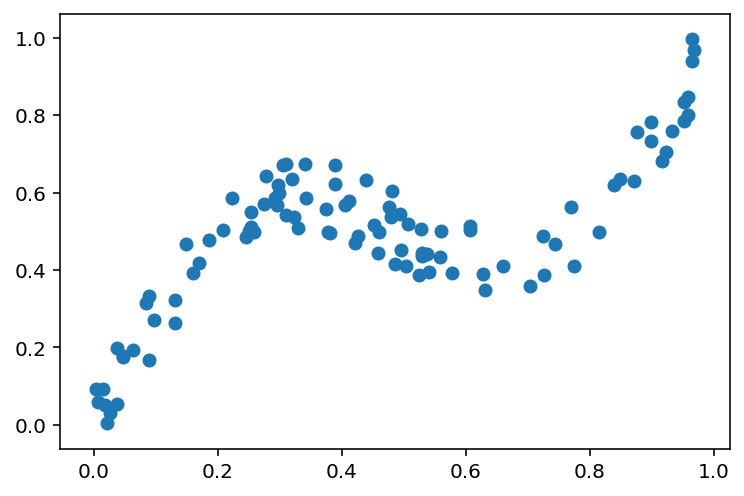

In [4]:
plt.scatter(xn, tn)

## The forward and inverse problems

In [5]:
xrange = np.linspace(0, 1, 100)

In [6]:
nn_forward = MLPRegressor(hidden_layer_sizes=(6, 6),
                  activation="tanh",
                  learning_rate_init=0.1,
                  solver="lbfgs", random_state=314)
nn_forward.fit(xn.reshape(-1, 1), tn)
yn_forward = nn_forward.predict(xrange.reshape(-1, 1))

In [7]:
nn_inverse = MLPRegressor(hidden_layer_sizes=(6, 6),
                  activation="tanh", 
                  learning_rate_init=0.1, tol=1e-6,
                  solver="lbfgs", random_state=3141)

nn_inverse.fit(tn.reshape(-1, 1), xn)
yn_inverse = nn_inverse.predict(xrange.reshape(-1, 1))

In [8]:
[c.shape for c in nn_forward.coefs_]

[(1, 6), (6, 6), (6, 1)]

In [9]:
[c.shape for c in nn_forward.intercepts_]

[(6,), (6,), (1,)]

In [10]:
print(f"Loss for the forward problem: {nn_forward.loss_:0.4f}")
print(f"Loss for the inverse problem: {nn_inverse.loss_:0.4f}")

Loss for the forward problem: 0.0017
Loss for the inverse problem: 0.0143


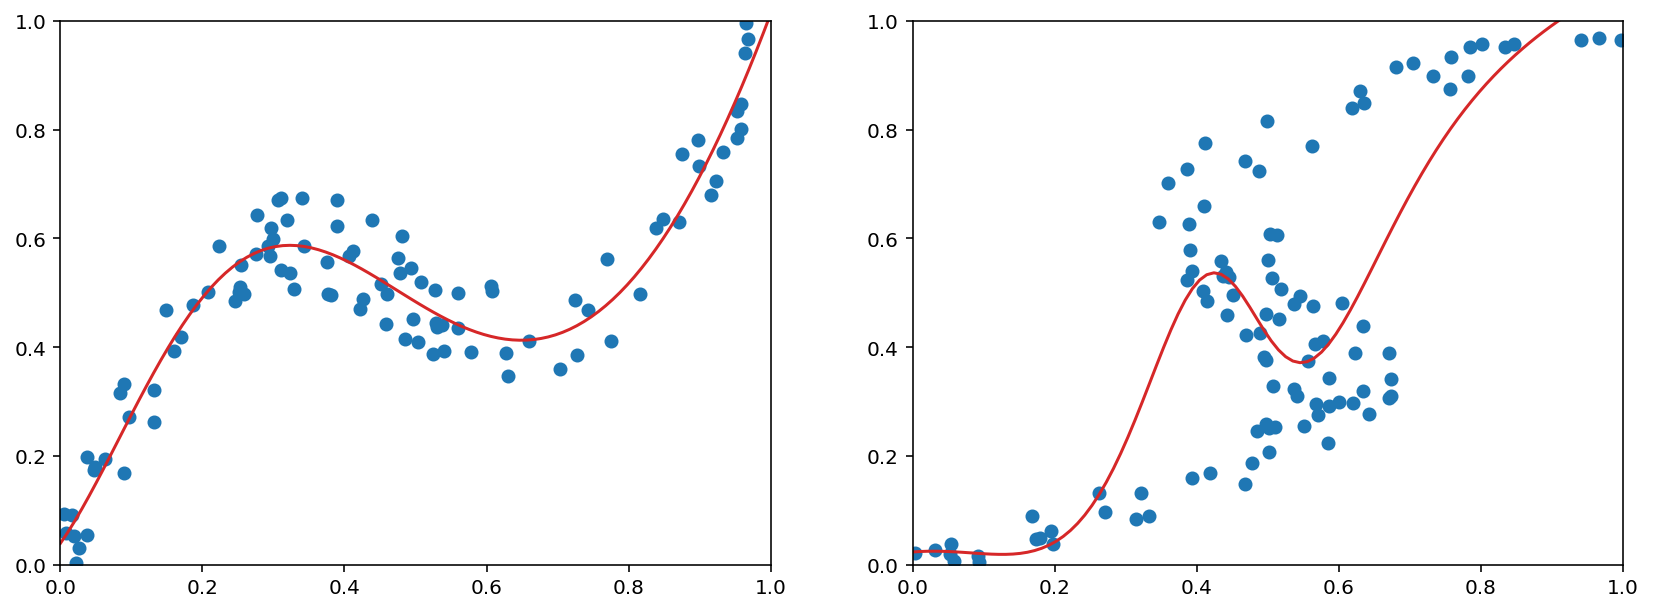

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].scatter(xn, tn)
ax[0].plot(xrange, yn_forward, c="tab:red")

ax[1].scatter(tn, xn)
ax[1].plot(xrange, yn_inverse, c="tab:red")

for axi in ax:
    axi.set_xlim(0, 1)
    axi.set_ylim(0, 1)

Choosing a least squares error function corresponds to a maximum likelihood under a Gaussian assumption. If the distribution of the parameters to fit is highly non-gaussian, the model cannot caputre the nature of the data.

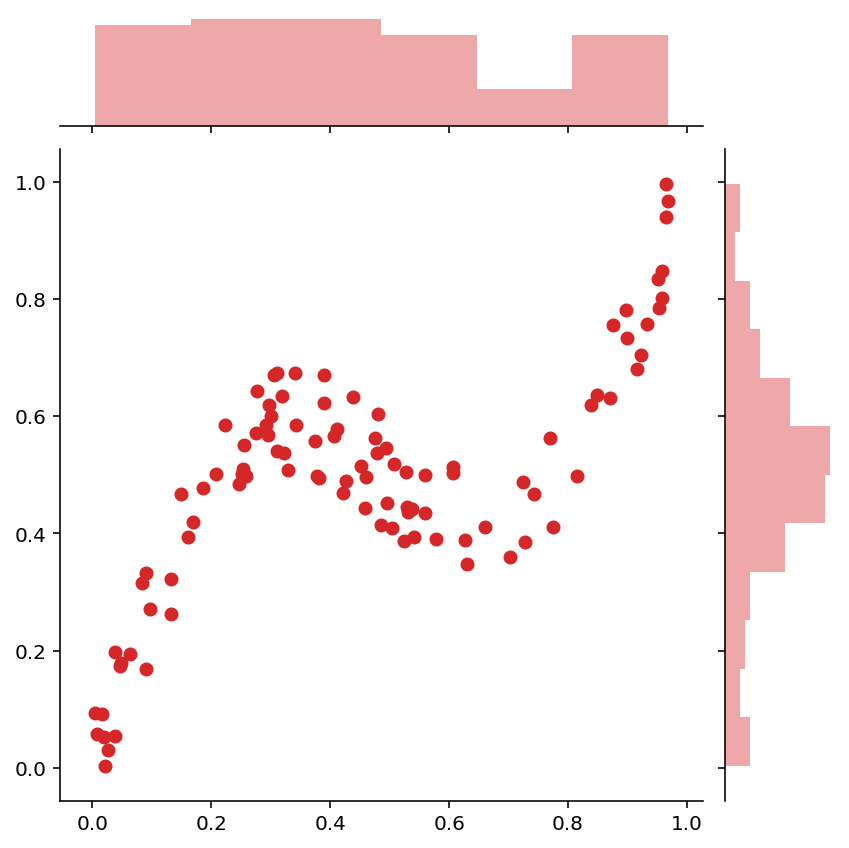

In [12]:
sns.jointplot(xn, tn, color="tab:red")

## Model Retraining

Before training the mixture density network, we begin by re-training the network using numpy and scipy so that we may debug and train the mixture using central diferences and L-BFGS

In [99]:
from scipy.optimize import minimize

In [100]:
seed(314)
w = normal(size=1 * 6 + 6 * 6 + 6 * 1 + 6 + 6 + 1)
w = np.clip(w, -1, 1)

In [101]:
def fforward(W, X):
    """
    A two-layered feed-forward activation function with "n" units
    at each hidden layer; one input unit; and one output unit
    """
    # weights
    w1 = W[:6].reshape(1, 6)
    w2 = W[6: 36 + 6].reshape(6, 6)
    w3 = W[42: 42 + 6].reshape(6, 1)
    # Biases
    wb1 = W[48:48 + 6]
    wb2 = W[54: 54 + 6]
    wb3 = W[60:]

    return np.tanh(np.tanh(X @ w1 + wb1) @ w2 + wb2) @ w3 + wb3

def nntrain(w, X, y):
    t = fforward(w, X).ravel()
    err2 = np.mean((t - y) ** 2) 
    return err2

### Central Differences Approximation

In [102]:
X = xn.reshape(-1, 1)

In [114]:
%%time
w0 = w.copy()
eps = 0.01
alpha = 0.7
epochs = 700
perturb = np.identity(w0.shape[0]) * eps

E_hist = []
for e in range(epochs):
    for ix, p in enumerate(perturb):
        w0[ix] = w0[ix] - alpha * (nntrain(w0 + p, X, tn) - nntrain(w0 - p, X, tn)) / (2 * eps)
    E_epoch = nntrain(w0, X, tn)
    E_hist.append(E_epoch)

CPU times: user 3.4 s, sys: 10.4 ms, total: 3.41 s
Wall time: 3.41 s


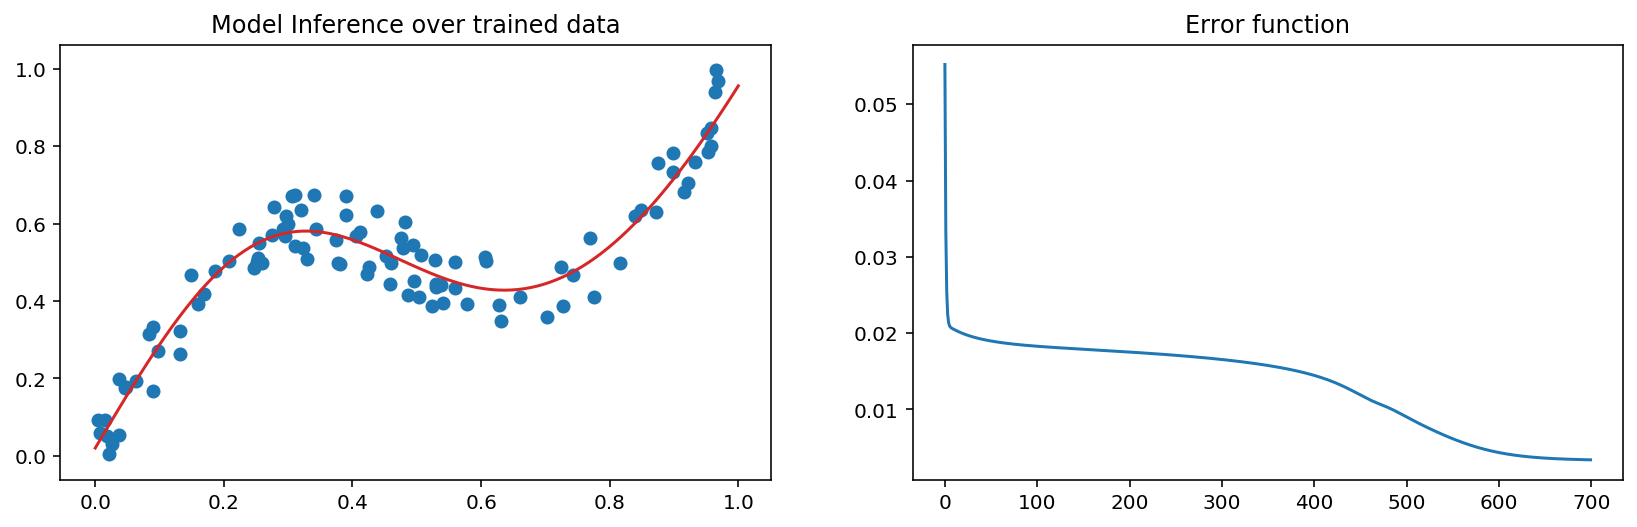

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].scatter(X, tn)
ax[0].plot(xrange, fforward(w0, xrange.reshape(-1, 1)), c="tab:red")
ax[1].plot(E_hist)
ax[0].set_title("Model Inference over trained data")
ax[1].set_title("Error function");

### With L-BFGS

In [19]:
%%time
nnw = minimize(nntrain, w, (X, tn), method="l-bfgs-b",
               tol=1e-20)
nnw

CPU times: user 697 ms, sys: 3.5 ms, total: 700 ms
Wall time: 701 ms


      fun: 0.00327825121316806
 hess_inv: <61x61 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.69403683e-04,  7.40553452e-07,  1.26964758e-04, -6.83654522e-07,
        7.25035483e-05, -2.90678766e-04, -2.29117289e-04,  6.87817858e-08,
        1.85181731e-08, -2.16840434e-09,  2.54739806e-06, -2.33593526e-06,
       -7.18196769e-05,  2.34621350e-08,  9.62771529e-09, -2.55871713e-09,
       -4.99864906e-06,  2.99274494e-06, -9.27011939e-05,  2.86663054e-08,
        1.14925430e-08, -1.47451495e-09, -1.89718033e-06,  9.36403732e-07,
       -6.55312610e-05,  2.18141477e-08,  9.15066634e-09, -2.51534904e-09,
       -5.15156494e-06,  2.97747937e-06, -2.33692709e-04,  6.84348411e-08,
        9.15066634e-09, -3.03576608e-09,  3.93938354e-06,  1.43374895e-07,
       -5.42192593e-05,  1.19262239e-08,  3.79470760e-08,  6.46184495e-09,
        5.17979756e-06, -4.07720732e-06, -8.09984892e-05, -6.06684408e-05,
       -6.13752972e-05,  6.13836672e-05,  5.75486273e-05, -6.93966152e-05,


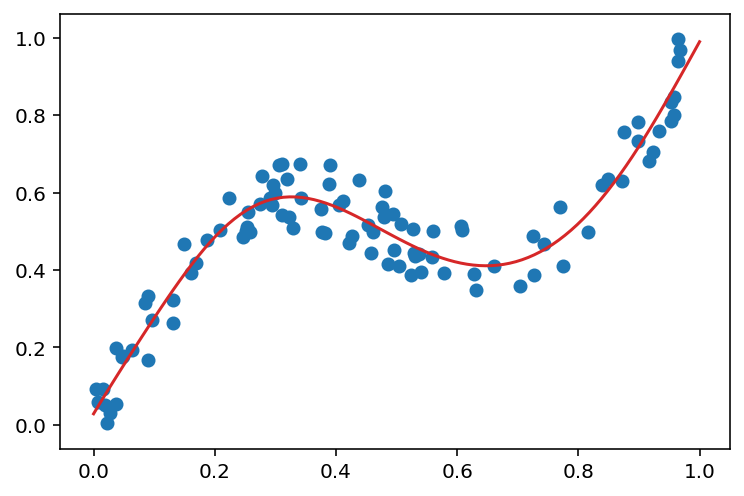

In [20]:
w0 = nnw.x
plt.scatter(X, tn)
plt.plot(xrange, fforward(w0, xrange.reshape(-1, 1)), c="tab:red")

## The Mixture Density Network

The loss function for the mixture density network is given by

$$
    E({\bf w}) = - \sum_{n=1}^N \ln\left\{\sum_{k=1}^K \pi_k({\bf x}_n, {\bf w})\mathcal{N}({\bf t}_n|{\boldsymbol \mu}_k({\bf x}, {\bf w}), {\bf I}\sigma_k^2
  ({\bf x}, {\bf w}))\right\}
$$

We will model the coeffients $\{\pi_k\}_k$, $\{{\boldsymbol \mu}_k\}_k$, and $\{\sigma_k\}_k$ as the outputs of a feed-forward neural network. In this example, we will consider three Gaussian components generated by a two-layer nnet with five `tanh` in each hidden layer and nine output units (three $\mu_k$s; three $\sigma_k$s; and three $\pi_k$s)

In [21]:
from scipy.stats import norm

In [642]:
def mixture(w, X, t):
    """
    Estimates the ouputs of a mixture density network
    """
    # Weights
    w1 = w[:nw1].reshape(ni, nh)
    w2 = w[nw1:nw2 + nw1].reshape(nh, nh)
    w3 = w[nw2 + nw1: nw3 + nw2 + nw1].reshape(nh, no)

    # biases
    wb1 = w[nw3 + nw2 + nw1: nb1 + nw3 + nw2 + nw1]
    wb2 = w[nb1 + nw3 + nw2 + nw1: nb2 + nb1 + nw3 + nw2 + nw1]
    wb3 = w[nb2 + nb1 + nw3 + nw2 + nw1: nb3 + nb2 + nb1 + nw3 + nw2 + nw1]
    
    coefs = np.tanh(np.tanh(X @ w1 + wb1) @ w2 + wb2) @ w3 + wb3
    a_pi = coefs[:, :3]
    a_mu = coefs[:, 3:6]
    a_sigma = coefs[:, 6:]

    pi = np.exp(a_pi) / np.exp(a_pi).sum(axis=1)[:, np.newaxis]
    mu = a_mu
    sigma = np.exp(a_sigma)
    
    return pi, mu, sigma

def mdn(w, X, t):
    """
    With a mixture density network, compute the probability of "t"
    given a vector "X" and a set of weights "w"
    """
    pi, mu, sigma = mixture(w, X, t)
    return (pi / np.sqrt(2 * np.pi * sigma ** 2) *
                      np.exp(-(t[:, np.newaxis] - mu) ** 2 / (2 * sigma ** 2))).sum(axis=-1)

def E(w, X, t):
    """
    Computes the negative log-likelihood error function for the
    mixture density nework.
    """
    mixture_gaussian = mdn(w, X, t)
    return -np.log(mixture_gaussian).sum()

In [643]:
seed(2718)
ni, nh, no = 1, 5, 9
nw1, nw2, nw3 = ni * nh, nh * nh, nh * no
nb1, nb2, nb3 = nh, nh, no

w = randn(ni * nh + nh * nh + nh * no + (nh + nh + no))

E(w, tn[:, np.newaxis], xn)

165.04386853677232

### Training the model with central differences

In [644]:
%%time
w0 = w.copy()
eps = 0.005
alpha = 0.001
epochs = 300
perturb = np.identity(w0.shape[0]) * eps

E_hist = []
for e in range(epochs):
    for ix, p in enumerate(perturb):
        print(f"@epoch {e:04}", end="\r")
        forward = E(w0 + p, tn[:, np.newaxis], xn)
        backward = E(w0 - p, tn[:, np.newaxis], xn)
        w0[ix] = w0[ix] - alpha * (forward - backward) / (2 * eps)
    E_epoch = E(w0, tn[:, np.newaxis], xn)
    E_hist.append(E_epoch)

CPU times: user 7.55 s, sys: 1.14 s, total: 8.68 s
Wall time: 8.02 s


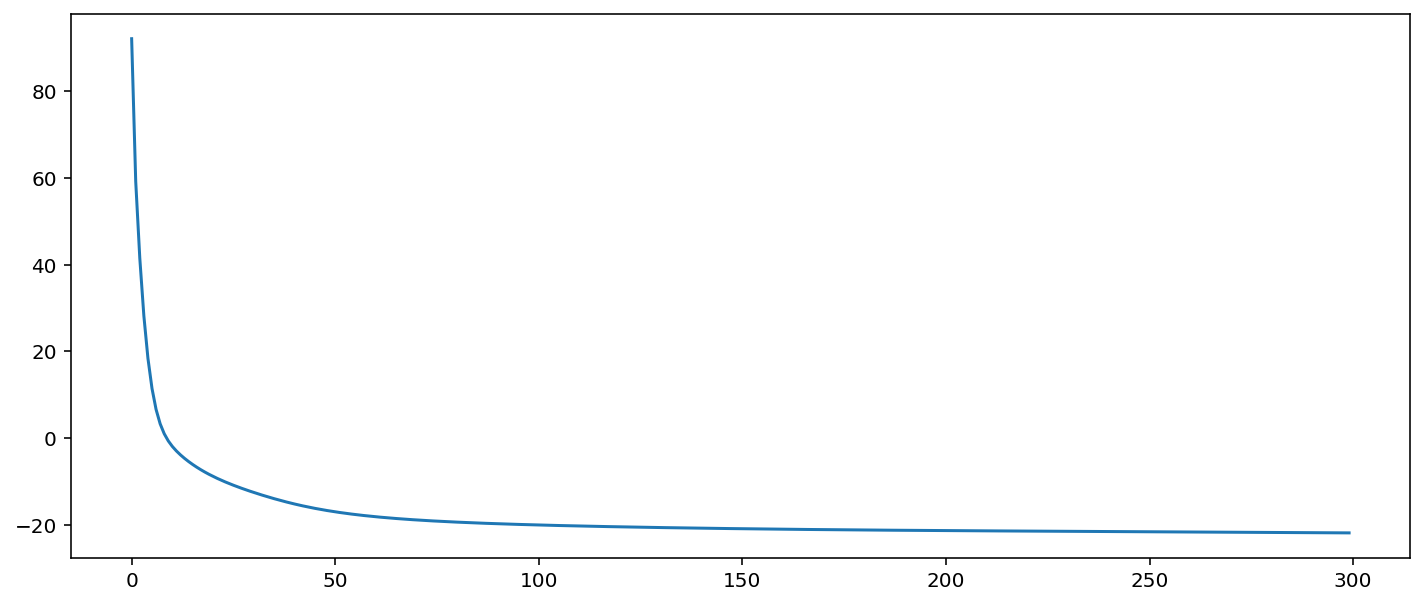

In [645]:
plt.figure(figsize=(12, 5))
plt.plot(E_hist)

In [646]:
grid = np.mgrid[-0.5:1:0.01, 0:1:0.01]
values = grid.T.reshape(-1, 2)
x = values[:, [0]]
t = values[:, 1]

In [663]:
mixture_gaussian = mdn(w0, x, t)

In [664]:
sx, sy = grid.shape[1:]
mixture_map = mixture_gaussian.reshape(sy, sx).T

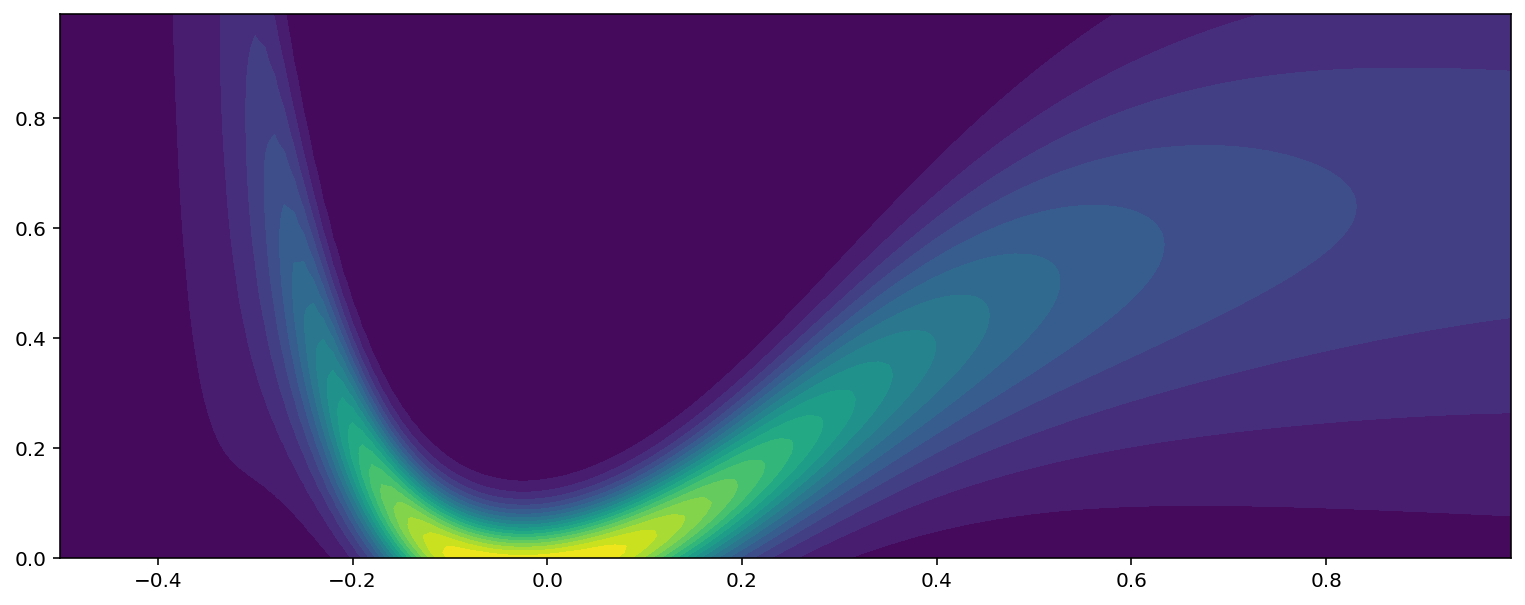

In [666]:
plt.figure(figsize=(13, 5))
plt.contourf(*grid, mixture_map, levels=20)

### Training the MDN with L-BFGS

In [619]:
nnw = minimize(E, w, (tn[:, np.newaxis], xn), method="l-bfgs-b",
               tol=1e-10)
nnw

      fun: -46.9421699658812
 hess_inv: <94x94 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -6.38 ,  -6.732,   0.   ,   5.289,   1.185,  -0.027,   2.461,
        -3.228,  16.432,  -0.136,   0.01 ,  -0.768,   2.22 ,  -7.875,
        -0.191,  -0.024,   2.712,   1.476,   2.23 ,  -0.918,  -0.005,
         0.42 ,  -1.422,   4.692,   0.11 ,   0.001,  -0.519,  -4.065,
         9.216,   1.011,   0.018,   0.006,  -0.023,  -0.002,   0.   ,
        36.172,  -0.002,   0.   ,   1.935,   0.017,   0.005,  -0.023,
        -0.002,   0.   ,  34.268,  -0.002,   0.   ,   1.991,  -0.005,
        -0.   ,   0.005,   0.001,   0.   ,  23.644,   0.001,  -0.   ,
        -1.17 ,   0.006,   0.002,  -0.008,  -0.001,   0.   ,  39.914,
        -0.001,   0.   ,   0.334,  -0.017,  -0.005,   0.022,   0.002,
        -0.   , -36.546,   0.002,  -0.   ,  -1.677,  -1.24 ,   9.485,
         0.251,  -0.486,  11.602,   0.025,  -2.84 ,  -1.351,  -2.631,
         0.914,   0.018,   0.006,  -0.023,  -0.002,   0.   ,  